# Create Forecasting Pipeline for LightGBM

In [1]:
# general import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional import
import geohash
import geopandas as gpd
import lightgbm as lgb

# local import
from rdforecast import datasets, models

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Data Preparation

## 1.1 Configuration
- Specify folder path for input files
- Check if `zone_labels.csv` exists
- If the repo is cloned/downloaded as a whole, the defaults should do.

In [2]:
# path to train, test, and zone_label data
path = './input/'

# zone_labels.csv is pre-generated and should be found in ./input/
# if not, it can be generated from explore_function_segmentation.ipynb
zone_labels = pd.read_csv(path+'zone_labels.csv')

# specify historical demands to generate features
history = [1, 2, 5,
           96, 96*7, 96*14,
           96+1, 96*7+1, 96*14+1,
           96+5, 96*7+5, 96*14+5]

## 1.2 Load datasets
- Training data
- Testing data
- Manually move both the training data and the hold-out testing data into the input folder.
- ([Training Data Source](https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip), or use `datasets.load_training_data` to download from URL)
- Specify respective filenames as needed, the remaining codes should work out themselves.

In [3]:
train = pd.read_csv(path+'train.csv')  # specify filename

train = datasets.process_timestamp(train)
train = train.merge(zone_labels, how='left', on='geohash6')
train_full = models.expand_timestep(train, test_data=False)  # test_data=False
train_full = models.generate_features(train_full, history)

Decoding geohash...
Expanding training data and fill NaNs with 0 demands for all timesteps per TAZ...
Might take a moment depending on machines...
Done.
Missing values:
geohash6            0
timestep            0
label_weekly_raw    0
label_weekly        0
label_daily         0
label_quarterly     0
active_rate         0
lon                 0
lat                 0
day                 0
weekly              0
quarter             0
hour                0
dow                 0
demand              0
dtype: int64
Retrieving historical demands...
Generating features...
Done.


In [4]:
test = pd.read_csv(path+'test.csv')  # specify filename

test = datasets.process_timestamp(test)
test = test.merge(zone_labels, how='left', on='geohash6')
test_full = models.expand_timestep(test, test_data=True)  # test_data=True
test_full = models.generate_features(test_full, history)

Decoding geohash...
Expanding testing data and fill NaNs with 0 demands for all timesteps per TAZ; also generating T+1 to T+5 slots for forecasting...
Might take a moment depending on machines...
Done.
Missing values:
geohash6            0
timestep            0
label_weekly_raw    0
label_weekly        0
label_daily         0
label_quarterly     0
active_rate         0
lon                 0
lat                 0
day                 0
weekly              0
quarter             0
hour                0
dow                 0
demand              0
dtype: int64
Retrieving historical demands...
Generating features...
Done.


## 1.3 Prepare data for model training and forecasting

In [5]:
# specify features to use (do not include 'geohash6' and 'demand')
features = ['timestep', 'label_weekly_raw', 'label_daily',
            'active_rate', 'day', 'weekly', 'quarter',
            'hour', 'dow', 'demand_t-1', 'demand_t-2',
            'demand_t-5', 'demand_t-96', 'demand_t-672',
            'demand_t-1344', 'demand_t-97', 'demand_t-101',
            'weekend', 'st_trend', 'mt_trend', 'mt_trend_1d',
            'mt_trend_1w', 'lt_trend_1d']

# specify which features to be treated as categorical
cate_vars = ['hour', 'dow', 'label_weekly_raw', 'label_daily']

In [6]:
# generate training set and validation set based on features
X_train, X_val, y_train, y_val = models.get_train_validate(train_full, features, split=40)
X_train, X_val = models.mitigate_history(X_train, X_val)

[dtypes of features (including demand):]
float64    20
int64       4
dtype: int64
Split train and validation sets on day 40
X_train: (5084160, 23)
y_train: (5084160,)
X_val: (889728, 23)
y_val: (889728,)


In [7]:
# generate testing set and forecasting set based on features
# NOTE: in current version, only X_forecast set will be used later
X_test, X_forecast, y_test, y_forecast = models.get_test_forecast(test_full, features)

[dtypes of features (including demand):]
float64    20
int64       4
dtype: int64
Split test and forecast sets
X_test: (1759296, 23)
y_test: (1759296,)
X_forecast: (7854, 23)
y_forecast: (7854,)


# 2. Modelling

## 2.1 Model training

In [8]:
params = {
    'num_leaves': 2**5,
    'objective': 'regression_l2',
    'max_depth': 10,
    'min_data_in_leaf': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'rmse',
    'num_threads': 8
}

dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cate_vars)
dval = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_vars, reference=dtrain)
bst = lgb.train(params, dtrain, valid_sets=[dtrain, dval],
                num_boost_round=1000,
                early_stopping_rounds=100,
                verbose_eval=50)

print('\n'.join(('%s: %.2f' % x) for x in sorted(
      zip(X_train.columns, bst.feature_importance('gain')),
      key=lambda x: x[1], reverse=True)))

/home/yuwen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/yuwen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.0805867	valid_1's rmse: 0.0841059
[100]	training's rmse: 0.0547675	valid_1's rmse: 0.0570665
[150]	training's rmse: 0.0405499	valid_1's rmse: 0.0424019
[200]	training's rmse: 0.0332374	valid_1's rmse: 0.0350708
[250]	training's rmse: 0.029618	valid_1's rmse: 0.0316085
[300]	training's rmse: 0.0278429	valid_1's rmse: 0.0300558
[350]	training's rmse: 0.0268933	valid_1's rmse: 0.0293259
[400]	training's rmse: 0.0263125	valid_1's rmse: 0.0289874
[450]	training's rmse: 0.0258925	valid_1's rmse: 0.0288191
[500]	training's rmse: 0.0256079	valid_1's rmse: 0.0286996
[550]	training's rmse: 0.0254046	valid_1's rmse: 0.0286261
[600]	training's rmse: 0.0252439	valid_1's rmse: 0.0285921
[650]	training's rmse: 0.0250848	valid_1's rmse: 0.0286018
Early stopping, best iteration is:
[599]	training's rmse: 0.0252485	valid_1's rmse: 0.0285913
demand_t-5: 1749496.92
demand_t-96: 639451.11
demand_t-97: 139161.05
demand_t-

## 2.2 Model prediction

### 2.2.1 baselines

In [9]:
# extract some baselines for output comparisons
models.get_baselines(train_full)

[Simple Baselines]
Naive T-1:
0.02580025354015726
Naive T-96 (1 day):
0.052818481811111956
Naive T-672 (1 week):
0.0497953774293416
T-1 + (T-96 - T-97):
0.0347300497319869
T-1 + (T-672 - T-673):
0.03828125904391044
Historical average (by 672 timesteps weekly cycle per TAZ):
0.034347577265756185


### 2.2.2 predict on test data (from T - 14 days up to T)

In [10]:
y_pred = models.cap(bst.predict(X_test))
print('Before mitigation:')
models.eval_RMSE(y_test, y_pred)

# mitigate history information in test set
X_test.loc[X_test.sample(frac=0.4).index, ['demand_t-1', 'st_trend', 'mt_trend']] = -1
X_test.loc[X_test.sample(frac=0.3).index, ['demand_t-2']] = -1

print('After mitigation:')
y_pred = models.cap(bst.predict(X_test))
models.eval_RMSE(y_test, y_pred)

Before mitigation:
0.025284618515627064
After mitigation:
0.028919256313317026


### 2.2.3 perform forecast (from T+1 to T+5)

In [11]:
y_forecast = bst.predict(X_forecast)
output = models.get_forecast_output(test_full, y_forecast, shift=True)
output.head(7)

,index,geohash6,day,timestamp,demand
0,1518744,qp02yc,62,0:0,0.027025
1,1518745,qp02yc,62,0:15,0.025712
2,1518746,qp02yc,62,0:30,0.023669
3,1518747,qp02yc,62,0:45,0.028959
4,1518748,qp02yc,62,1:0,0.029626
5,1082694,qp02yf,62,0:0,0.048452
6,1082695,qp02yf,62,0:15,0.043843


## 2.3 Model evaluation

### 2.3.1 visualization

In [12]:
# recover test set info
# TODO: set index aforehand to avoid the trouble
split = test_full['timestep'].max() - 6
X_test_ = test_full[test_full['timestep'] <= split]
result = pd.concat([X_test_.reset_index(drop=True), pd.Series(y_test.values), pd.Series(y_pred)], axis=1, ignore_index=True)
result.columns = list(X_test_.columns) + ['y_test', 'y_pred']
result['geohash6'] = [geohash.encode(lat, lon, 6) for lon, lat in zip(result['lon'], result['lat'])]

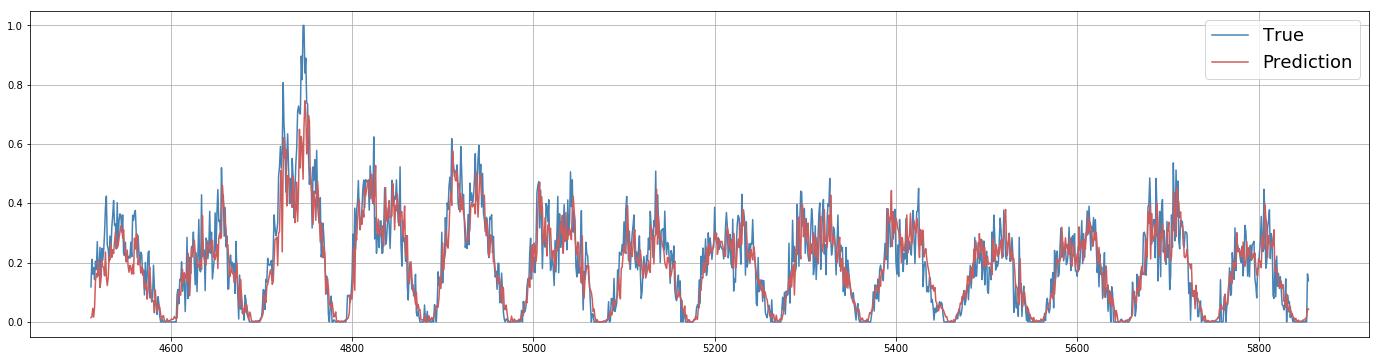

In [13]:
# long-term window
taz = 'qp02zt'
models.plot_forecast(result, taz)

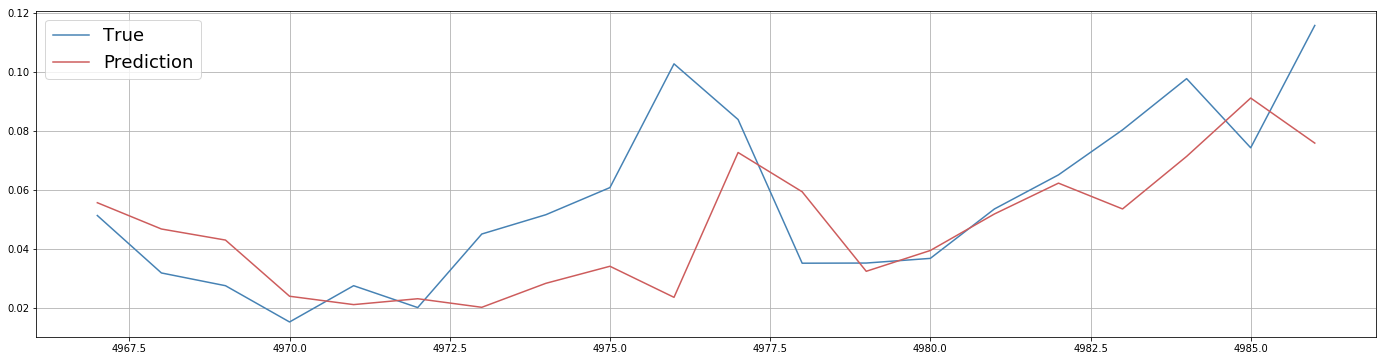

In [16]:
# short-term window
s = 455
e = 475
taz = 'qp03r0'
models.plot_forecast(result, taz, s, e)

### 2.3.1 errors

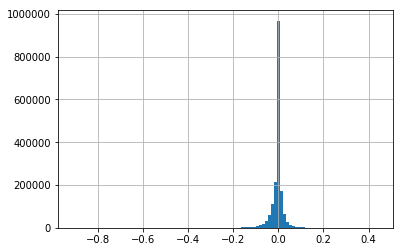

In [18]:
result['diff'] = (y_pred - y_test)
result['diff'].hist(bins=100);

#### analyze by zones that have higher errors

In [19]:
bad = result[np.abs(result['diff']) >= result['diff'].std() * 3]
good = result[np.abs(result['diff']) <= 0.001]

In [20]:
bad['geohash6'].value_counts()[:5]

qp0d1c    330
qp0d17    327
qp03xr    323
qp099w    322
qp03tc    290
Name: geohash6, dtype: int64

In [21]:
good['geohash6'].value_counts()[:5]

qp09s0    1150
qp0d5k    1139
qp09mf    1138
qp09t3    1134
qp09n1    1133
Name: geohash6, dtype: int64

#### analyze by zone functions (temporal pattern clustering labels)

In [22]:
i = 3
result[result['label_weekly_raw'] == i]['geohash6'].unique()[:10]

array(['qp096z', 'qp02zz', 'qp09dc', 'qp096x', 'qp03wf', 'qp02zw',
       'qp096v', 'qp09eq', 'qp096r', 'qp03qg'], dtype=object)